## 제주 빅데이터 경진대회

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgunbd.ttf').get_name()
mpl.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.16.6
Python 3.7.7


## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

변수명
- REG_YYMM :년월
- CARD_SIDO_NM : 카드이용지역_시도 (가맹점 주소 기준)
- CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
- STD_CLSS_NM : 업종명
- HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
- HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)
- AGE: 연령대
- SEX_CTGO_CD : 성별 (1: 남성, 2: 여성)
- FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
- CSTMR_CNT : 이용고객수 (명)
- AMT : 이용금액 (원) - 종속변수
- CNT : 이용건수 (건)

In [4]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [5]:
# 날짜 처리
data = pd.read_csv('D:/data/dacon/jeju/201901-202003.csv')
data = data.fillna('')
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)

In [6]:
data[data['CNT']==data['CNT'].max()]

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
12230816,경기,화성시,체인화 편의점,경기,화성시,30s,1,2,32728,924209390,120357,2019,8


- 행 해석: 19년 8월 한달동안 화성시의 30대 남성들의(영유아자녀가구) 화성시 편의점 고객의 수는 32728명이고 소비 횟수는 120357번이며 총 사용 금액은 924209390원이다.
 - 즉 한명의 고객이 같은 편의점에서 여러번 소비를 했다는 뜻

In [7]:
#중복된 행의 데이터만 표시하기
check = data[data.columns[:-3]]
display(check[check.duplicated()])

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT
1612230,강원,강릉시,욕탕업,경기,안산시 단원구,30s,2,2,3,43000
1612350,강원,강릉시,일식 음식점업,강원,삼척시,20s,2,1,3,104500
1616720,강원,강릉시,한식 음식점업,서울,동대문구,70s,1,5,3,80000
1625464,강원,속초시,건강보조식품 소매업,강원,양양군,60s,1,5,3,226800
1627352,강원,속초시,기타 외국식 음식점업,경기,파주시,30s,1,2,4,103000
...,...,...,...,...,...,...,...,...,...,...
24694864,충북,충주시,차량용 주유소 운영업,강원,원주시,30s,1,1,3,15000
24694986,충북,충주시,차량용 주유소 운영업,경기,수원시 팔달구,60s,1,5,3,170000
24695312,충북,충주시,차량용 주유소 운영업,대전,서구,50s,2,4,3,160000
24695989,충북,충주시,체인화 편의점,서울,구로구,40s,1,3,3,16900


"카드이용 정보가 같은 경우가 있을지" 이다.
- 없음 (모두 다름)
- **결론적으로 각 지역의 업종별로 '어떤 고객(고객 지역,성별,가족 생애주기 등)'들이 구성되어 있는지 확인을 하는 것이 중요해 보인다.**

In [8]:
data.shape

(24697792, 13)

In [9]:
data.isna().sum()

CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
AMT             0
CNT             0
year            0
month           0
dtype: int64

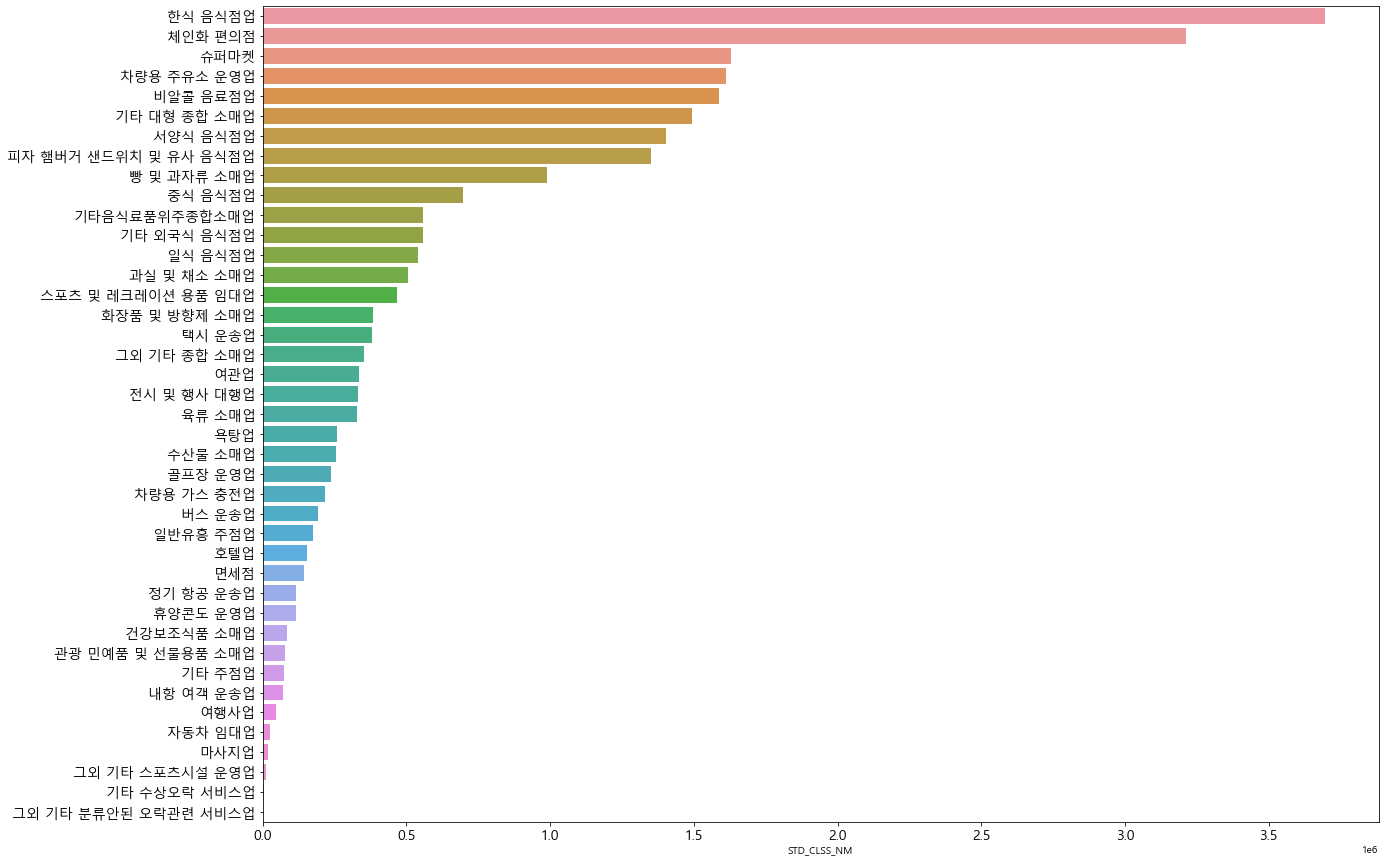

In [19]:
# 업종별 등장 빈도수
fig = plt.figure(figsize=(20, 15))
# fig.patch.set_facecolor('xkcd:mint green')
sns.barplot(y=data['STD_CLSS_NM'].value_counts().index,x=data['STD_CLSS_NM'].value_counts())
plt.tick_params(labelsize=14)
#plt.tight_layout()

In [10]:
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1


In [ ]:
city_count= data.groupby(['CARD_SIDO_NM','CARD_CCG_NM'])['STD_CLSS_NM'].value_counts().reset_index(name='count')
city_count.head()

In [ ]:
# 사실상 시,군,구 변수는 활용을 할 수 없기때문에 도별로 접근하는 것이 좋을 것으로 보인다.
city_sum = city_count.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])['count'].sum().reset_index(name='sum')
city_sum.head()

In [8]:
# 데이터 정제
df = data.copy()
df = df.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)

columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [9]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

## 3. 탐색적 자료분석
## Exploratory Data Analysis

In [9]:
# 입력하세요.

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [10]:
# feature, target 설정
train_num = df_num.sample(frac=1, random_state=0)
x = train_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
y = np.log1p(train_num['AMT'])

In [11]:
k = int(len(x)*0.9)

In [12]:
x_train = x[:k]
y_train = y[:k]
x_val = x[k:]
y_val = y[k:]

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [13]:
import lightgbm as lgb

In [14]:
train_ds = lgb.Dataset(x_train, label=y_train)
val_ds = lgb.Dataset(x_val, label=y_val)

In [15]:
params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

In [16]:
model = lgb.train(params,
                  train_ds,
                  1000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.98152
[200]	valid_0's rmse: 1.81073
[300]	valid_0's rmse: 1.68877
[400]	valid_0's rmse: 1.6029
[500]	valid_0's rmse: 1.51398
[600]	valid_0's rmse: 1.44908
[700]	valid_0's rmse: 1.39724
[800]	valid_0's rmse: 1.35602
[900]	valid_0's rmse: 1.31433
[1000]	valid_0's rmse: 1.27941
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.27941


## 6. 결과 및 결언
## Conclusion & Discussion

In [17]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=x.columns)

In [18]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [19]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [20]:
temp.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,2.353337e+08
1,202004,강원,골프장 운영업,1.601208e+09
2,202004,강원,과실 및 채소 소매업,6.451061e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,6.329203e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,2.724102e+07


In [ ]:
print("ACC : ", accuracy_score(y_test, pred))

In [ ]:
# 제출 파일 만들기
submission = pd.read_csv('data/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('submission.csv', encoding='utf-8-sig')
submission.head()